In [73]:
import os
import sys
import sqlite3
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import DBSCAN

sys.path.append(r'C:\Users\Pooya\w\GitHub\ShiraziPooya\DroughtMonitoringIran')

### Load Data

In [74]:
DATABASE_PATH = "../database/database.db"

conn = sqlite3.connect(database=DATABASE_PATH)
data = pd.read_sql(sql='SELECT * FROM data', con=conn)
data['station_id'] = data['station_id'].astype(str)
data['date'] = pd.to_datetime(data['date'])
conn.close()

In [75]:
data

,region_id,region_name,station_name,station_id,lat,lon,station_elevation,date,tmax,tmin,...,ERA5_SPI_24,ERA5_SPEI_24,GPM_SPI_24,GPM_SPEI_24,PERSIANN_CDR_SPI_24,PERSIANN_CDR_SPEI_24,TRMM_SPI_24,TRMM_SPEI_24,TerraClimate_SPI_24,TerraClimate_SPEI_24
0,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,1980-01-01,9.55,1.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,1980-02-01,8.46,2.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,1980-03-01,10.53,5.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,1980-04-01,15.83,10.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,1980-05-01,20.67,14.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8230,MASA,Mazandaran,Alasht,99361,36.07,52.84,1805.0,2025-05-01,22.36,11.35,...,-0.960,NaN,-1.378,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8231,MASA,Mazandaran,Alasht,99361,36.07,52.84,1805.0,2025-06-01,20.64,11.66,...,-1.353,NaN,-1.689,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8232,MASA,Mazandaran,Alasht,99361,36.07,52.84,1805.0,2025-07-01,24.43,15.14,...,-0.881,NaN,-1.555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8233,MASA,Mazandaran,Alasht,99361,36.07,52.84,1805.0,2025-08-01,26.52,16.82,...,-1.584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Prepare the Data

In [76]:
REGION = "Mazandaran"
START_DATE = "2005-09-01"
END_DATE = "2024-09-01"

df = data.query('region_name == @REGION').query("date >= @START_DATE and date < @END_DATE")

df.groupby(["region_id", "region_name", "station_id", "station_name"]).agg({
    'tm': 'count',
    'tmin': 'count',
    'tmax': 'count',
    'rrr24': 'count',
    'Hargreaves': 'count'
})


tm  tmin  tmax  \
region_id region_name station_id station_name                                  
MASA      Mazandaran  40732      Ramsar                      228   228   228   
                      40734      Nowshahr                    228   228   228   
                      40735      Siahbisheh                  228   228   228   
                      40736      Babolsar                    228   228   228   
                      40737      Gharakhil                   228   228   228   
                      40759      Sari                        228   228   228   
                      40760      Kiyasar                     228   228   228   
                      40788      Sari (Dasht-E-Naz Airport)  224   224   224   
                      99299      Galugah                     228   228   228   
                      99306      Bandar-E-Amirabad           228   228   228   
                      99309      Amol                        228   228   228   
                      99348      Kojur                       222   222   222   
                      99357      Baladeh                     222   222   222   
                      99360      Polsefid                    228   228   228   
                      99361      Alasht                      228   228   228   

                                                             rrr24  Hargreaves  
region_id region_name station_id station_name                                   
MASA      Mazandaran  40732      Ramsar                        228         228  
                      40734      Nowshahr                      228         228  
                      40735      Siahbisheh                    228         228  
                      40736      Babolsar                      228         228  
                      40737      Gharakhil                     228         228  
                      40759      Sari                          228         228  
                      40760      Kiyasar                       228         228  
                      40788      Sari (Dasht-E-Naz Airport)    224         224  
                      99299      Galugah                       228         228  
                      99306      Bandar-E-Amirabad             228         228  
                      99309      Amol                          228         228  
                      99348      Kojur                         222         222  
                      99357      Baladeh                       222         222  
                      99360      Polsefid                      228         227  
                      99361      Alasht                        228         228

In [77]:
station_data = df.groupby(["region_id", "region_name", "station_id", "station_name", data["date"].dt.year]).agg({
    'tm': 'mean',
    'tmax': 'mean',
    'tmin': 'mean',
    'rrr24': 'sum',
    'lat': 'first',
    'lon': 'first',
    'station_elevation': 'first',
}).groupby(["region_id", "region_name", "station_id", "station_name"]).agg({
    'tm': 'mean',
    'tmax': 'mean',
    'tmin': 'mean',
    'rrr24': 'mean',
    'lat': 'first',
    'lon': 'first',
    'station_elevation': 'first',
}).reset_index()

station_data['DT'] = station_data['tmax'] - station_data['tmin']

scaler = StandardScaler()
features = ["tm", "rrr24", "station_elevation", "DT"]
station_data_scaled = scaler.fit_transform(station_data[features])

### Apply Clustering Algorithm

##### K-Means Clustering

In [78]:
k = 3

kmeans = KMeans(n_clusters=k, random_state=42)

station_data['Cluster'] = kmeans.fit_predict(station_data_scaled)
station_data['Cluster'] = station_data['Cluster'] + 1


station_data.Cluster.value_counts()

Cluster
1    8
2    5
3    2
Name: count, dtype: int64

In [79]:
names = {
    "Ramsar":	"رامسر",
    "Nowshahr":	"نوشهر",
    "Siahbisheh":	"سیاه بیشه",
    "Babolsar":	"بابلسر",
    "Gharakhil":	"قراخیل",
    "Sari":	"ساری",
    "Kiyasar":	"کیاسر",
    "Sari (Dasht-E-Naz Airport)": "فرودگاه ساری",
    "Galugah":	"گلوگاه",
    "Bandar-E-Amirabad": "بندر امیرآباد",
    "Amol":	"آمل",
    "Kojur":	"کجور",
    "Baladeh":	"بلده",
    "Polsefid":	"پل سفید",
    "Alasht":	"آلاشت",
}

station_data['station_name_fa'] = station_data['station_name'].map(names)

station_data

,region_id,region_name,station_id,station_name,tm,tmax,tmin,rrr24,lat,lon,station_elevation,DT,Cluster,station_name_fa
0,MASA,Mazandaran,40732,Ramsar,17.442000,20.553000,14.331375,1198.3085,36.90,50.68,-20.0,6.221625,3,رامسر
1,MASA,Mazandaran,40734,Nowshahr,17.260000,20.669354,13.853333,1254.8315,36.66,51.47,-20.9,6.816021,3,نوشهر
2,MASA,Mazandaran,40735,Siahbisheh,11.323688,15.909271,6.735333,503.5890,36.23,51.30,1855.4,9.173937,2,سیاه بیشه
3,MASA,Mazandaran,40736,Babolsar,18.373562,21.914437,14.839417,817.1260,36.70,52.64,-21.0,7.075021,1,بابلسر
4,MASA,Mazandaran,40737,Gharakhil,17.763979,22.637083,12.886896,651.2560,36.49,52.11,14.7,9.750188,1,قراخیل
5,MASA,Mazandaran,40759,Sari,18.580646,23.356104,13.808438,698.6395,36.54,53.00,23.0,9.547667,1,ساری
6,MASA,Mazandaran,40760,Kiyasar,13.660708,18.749042,8.576562,503.5940,36.25,53.55,1294.3,10.172479,2,کیاسر
7,MASA,Mazandaran,40788,Sari (Dasht-E-Naz Airport),17.986689,22.938816,13.033925,580.5180,36.64,53.20,16.7,9.904890,1,فرودگاه ساری
8,MASA,Mazandaran,99299,Galugah,17.855354,22.872625,12.833000,537.9295,36.74,53.84,-10.0,10.039625,1,گلوگاه
9,MASA,Mazandaran,99306,Bandar-E-Amirabad,17.978458,21.777479,14.179438,584.4755,36.86,53.39,-20.0,7.598042,1,بندر امیرآباد


## 2D Plot

In [80]:
station_data['Cluster'] = station_data['Cluster'].astype(str)

cluster_properties = {
    1: {'symbol': 'circle', 'color': 'black'},
    2: {'symbol': 'diamond', 'color': 'red'},
    3: {'symbol': 'diamond-open', 'color': 'blue'}
}

fig = px.scatter(
    station_data,
    x="tm",
    y="rrr24",
    color="Cluster",
    color_continuous_scale="Viridis",
    hover_name=station_data['station_name'],
    text="station_name_fa", 
    height=600,
    width=600
)

for cluster_id, properties in cluster_properties.items():
    fig.update_traces(
        selector=dict(name=str(cluster_id)),
        marker=dict(
            symbol=properties['symbol'],
            color=properties['color'],
            size=10
        )
    )

fig.update_layout(
    template="plotly_white",
    # bordercolor='black',
    # title={
    #     'text': "دمای متوسط در مقابل مجموع بارش بر اساس خوشه‌ها",
    #     'x': 0.5,  # Center the title
    #     'xanchor': 'center',
    #     'yanchor': 'top',
    #     'font': {'size': 24, 'family': 'B Zar'}  # Change title font and size
    # },
    xaxis_title="(درجه سانتیگراد) دمای متوسط",
    yaxis_title="بارش (میلیمتر)",
    font={
        'family': 'B Zar',
        'size': 24
    },
    legend_title="خوشه‌ها",
    legend=dict(
        font=dict(
            size=18
        )
    ),
    # xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
    # yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.update_layout(
    xaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        linecolor='black',
        linewidth=1,
        ticks='inside',
        ticklen=6,
        tickwidth=1, 
        dtick=1
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        linecolor='black',
        linewidth=1,
        ticks='inside',
        ticklen=6,
        tickwidth=1,
        dtick=150
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    shapes=[
        dict(
            type="rect",
            x0=0,
            x1=1,
            y0=0,
            y1=1,
            xref="paper",
            yref="paper",
            line=dict(
                color="black",
                width=2
            )
        )
    ]
)

fig.update_traces(
    textposition='top right',  # Specifies where the text appears relative to the marker
    textfont=dict(              # Controls the font style of the text
        family='B Zar',
        size=14,
        color='black'
    )
)


fig.show()

## 3D Plot

In [81]:
station_data['Cluster'] = station_data['Cluster'].astype(int)

custom_colors = {
    1: 'black',
    2: 'red',
    3: 'blue'
}

colors = [custom_colors.get(cluster, 'gray') for cluster in station_data['Cluster']]

cluster_shapes = {
    1: 'circle',
    2: 'diamond',
    3: 'diamond-open'
}

shapes = [cluster_shapes.get(cluster, 'triangle-up') for cluster in station_data['Cluster']]

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=round(station_data["tm"], 1),
            y=round(station_data["rrr24"], 1),
            z=round(station_data["station_elevation"], 1),
            mode="markers",
            marker=dict(
                size=8,
                color=colors,
                symbol=shapes,
                opacity=0.8,
            ),
            text=station_data["station_name"],
            hovertemplate=(
                'Station: %{text}<br>'
                'Temperature: %{x}<br>'
                'Precipitation: %{y}<br>'
                'Elevation: %{z}<br>'
                '<extra></extra>'
            )
        )
    ]
)

fig.update_layout(

    scene=dict(
        xaxis_title="دمای متوسط (درجه سانتیگراد)",
        yaxis_title="بارندگی (میلیمتر)",
        zaxis_title="ارتفاع ایستگاه (متر)",
        # xaxis=dict(
        #     autorange='reversed'
        # ),
        # yaxis=dict(
        #     autorange='reversed'
        # ),
    ),
    width=800,
    height=800,
    margin=dict(l=0, r=0, t=0, b=0),
    font={
        'family': 'B Zar',
        'size': 18
    },
)

fig.show()


## Map

In [82]:
station_data

,region_id,region_name,station_id,station_name,tm,tmax,tmin,rrr24,lat,lon,station_elevation,DT,Cluster,station_name_fa
0,MASA,Mazandaran,40732,Ramsar,17.442000,20.553000,14.331375,1198.3085,36.90,50.68,-20.0,6.221625,3,رامسر
1,MASA,Mazandaran,40734,Nowshahr,17.260000,20.669354,13.853333,1254.8315,36.66,51.47,-20.9,6.816021,3,نوشهر
2,MASA,Mazandaran,40735,Siahbisheh,11.323688,15.909271,6.735333,503.5890,36.23,51.30,1855.4,9.173937,2,سیاه بیشه
3,MASA,Mazandaran,40736,Babolsar,18.373562,21.914437,14.839417,817.1260,36.70,52.64,-21.0,7.075021,1,بابلسر
4,MASA,Mazandaran,40737,Gharakhil,17.763979,22.637083,12.886896,651.2560,36.49,52.11,14.7,9.750188,1,قراخیل
5,MASA,Mazandaran,40759,Sari,18.580646,23.356104,13.808438,698.6395,36.54,53.00,23.0,9.547667,1,ساری
6,MASA,Mazandaran,40760,Kiyasar,13.660708,18.749042,8.576562,503.5940,36.25,53.55,1294.3,10.172479,2,کیاسر
7,MASA,Mazandaran,40788,Sari (Dasht-E-Naz Airport),17.986689,22.938816,13.033925,580.5180,36.64,53.20,16.7,9.904890,1,فرودگاه ساری
8,MASA,Mazandaran,99299,Galugah,17.855354,22.872625,12.833000,537.9295,36.74,53.84,-10.0,10.039625,1,گلوگاه
9,MASA,Mazandaran,99306,Bandar-E-Amirabad,17.978458,21.777479,14.179438,584.4755,36.86,53.39,-20.0,7.598042,1,بندر امیرآباد


In [96]:
geo_info_map = station_data.copy()

geo_info_map['Cluster'] = geo_info_map['Cluster'].astype(str)

geo_info_map['Hover_Info'] = geo_info_map.apply(
    lambda row: f"""
    Station Name: <b>{row['station_name']}</b><br>
    Station ID: <b>{row['station_id']}</b><br>
    Province: <b>{row['region_name']}</b><br>
    Latitude: <b>{row['lat']}</b><br>
    Longitude: <b>{row['lon']}</b><br>
    Elevation: <b>{row['station_elevation']} m</b><br>
    Temperature: <b>{round(row['tm'], 1)}</b><br>
    Precipitation: <b>{round(row['rrr24'], 1)}</b><br>
    DT: <b>{round(row['DT'], 1)}</b><br>
    """,
    axis=1
)

shapefile_path = "../assets/geo_data/Iran_1400/Ostan.shp"
gdf = gpd.read_file(shapefile_path)
geojson = gdf.to_crs(epsg=4326).__geo_interface__

cluster_colors = {
    "1": "black",
    "2": "darkred",
    "3": "darkblue",
}

fig = px.scatter_mapbox(
    geo_info_map,
    lat=geo_info_map.lat,
    lon=geo_info_map.lon,
    # size="Cluster",
    color="Cluster",
    color_discrete_map=cluster_colors,
    hover_name=geo_info_map['station_name'],
    hover_data={'station_id': True, 'station_name': False, 'Hover_Info': False},
    custom_data=['Hover_Info'],
    text="station_name",
    zoom=7.5,
    height=600,
    width=1200
)


# fig.update_layout(
#     mapbox=dict(
#         layers=[
#             {
#                 "source": geojson,
#                 "type": "line",  # "fill" for filled polygons
#                 "color": "black",
#                 "line": {"width": 2},
#                 "below": "traces"
#             }
#         ],
#     )
# )

# Add map style
fig.update_layout(
    # mapbox_style="open-street-map",
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        },
        {
            "source": geojson,
            "type": "line",
            "color": "white",
            "line": {"width": 4},
            "below": "traces"
        }
    ],
    margin={"r":0,"t":0,"l":0,"b":0},
    hoverlabel=dict(        
        bgcolor="white",
        font_size=16,
        font_family="Arial",
        align="left"
    ),
    legend=dict(
        yanchor="top",
        y=0.98,
        xanchor="left",
        x=0.01,
        title="",
        traceorder="normal",
        title_font_family="Times New Roman",
        font=dict(
            family="Times New Roman",
            size=14,
            color="black"
        ),
        bgcolor="snow",
        bordercolor="Black",
        borderwidth=0.5
    )
)

fig.update_traces(textfont_size=14, textposition="top right", textfont_color="black") 

fig.update_traces(
    hovertemplate="%{customdata[0]}",
    marker=dict(size=20)
)

# Show the plot
fig.show()

C:\Users\Pooya\AppData\Local\Temp\ipykernel_16852\2393771896.py:30: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



Cluster 1: Sari   
Cluster 2: Alasht    
Cluster 3: Ramsar  

In [97]:
geo_info_map

,region_id,region_name,station_id,station_name,tm,tmax,tmin,rrr24,lat,lon,station_elevation,DT,Cluster,station_name_fa,Hover_Info
0,MASA,Mazandaran,40732,Ramsar,17.442000,20.553000,14.331375,1198.3085,36.90,50.68,-20.0,6.221625,3,رامسر,\n Station Name: <b>Ramsar</b><br>\n Sta...
1,MASA,Mazandaran,40734,Nowshahr,17.260000,20.669354,13.853333,1254.8315,36.66,51.47,-20.9,6.816021,3,نوشهر,\n Station Name: <b>Nowshahr</b><br>\n S...
2,MASA,Mazandaran,40735,Siahbisheh,11.323688,15.909271,6.735333,503.5890,36.23,51.30,1855.4,9.173937,2,سیاه بیشه,\n Station Name: <b>Siahbisheh</b><br>\n ...
3,MASA,Mazandaran,40736,Babolsar,18.373562,21.914437,14.839417,817.1260,36.70,52.64,-21.0,7.075021,1,بابلسر,\n Station Name: <b>Babolsar</b><br>\n S...
4,MASA,Mazandaran,40737,Gharakhil,17.763979,22.637083,12.886896,651.2560,36.49,52.11,14.7,9.750188,1,قراخیل,\n Station Name: <b>Gharakhil</b><br>\n ...
5,MASA,Mazandaran,40759,Sari,18.580646,23.356104,13.808438,698.6395,36.54,53.00,23.0,9.547667,1,ساری,\n Station Name: <b>Sari</b><br>\n Stati...
6,MASA,Mazandaran,40760,Kiyasar,13.660708,18.749042,8.576562,503.5940,36.25,53.55,1294.3,10.172479,2,کیاسر,\n Station Name: <b>Kiyasar</b><br>\n St...
7,MASA,Mazandaran,40788,Sari (Dasht-E-Naz Airport),17.986689,22.938816,13.033925,580.5180,36.64,53.20,16.7,9.904890,1,فرودگاه ساری,\n Station Name: <b>Sari (Dasht-E-Naz Airpo...
8,MASA,Mazandaran,99299,Galugah,17.855354,22.872625,12.833000,537.9295,36.74,53.84,-10.0,10.039625,1,گلوگاه,\n Station Name: <b>Galugah</b><br>\n St...
9,MASA,Mazandaran,99306,Bandar-E-Amirabad,17.978458,21.777479,14.179438,584.4755,36.86,53.39,-20.0,7.598042,1,بندر امیرآباد,\n Station Name: <b>Bandar-E-Amirabad</b><b...


##### Hierarchical Clustering

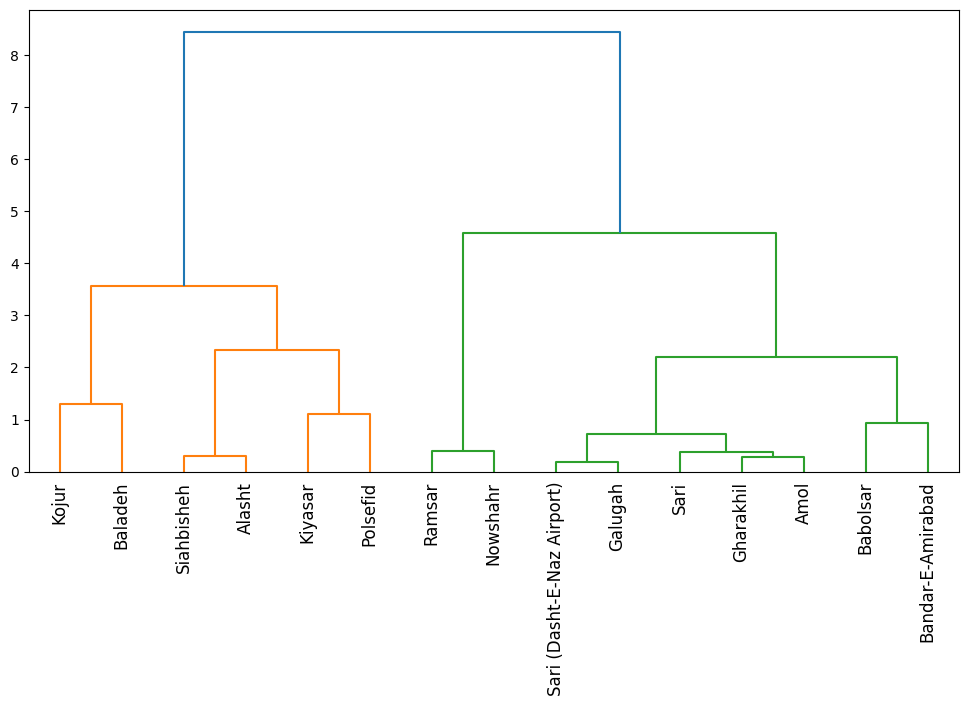

In [98]:
# Perform hierarchical clustering
Z = linkage(station_data_scaled, method='ward')

# Visualize dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=station_data['station_name'].values)
plt.xticks(rotation=90)
plt.show()

In [99]:
geo_info_map['Cluster'] = geo_info_map['Cluster'].astype(str)
geo_info_map = geo_info_map.sort_values('Cluster').reset_index(drop=True)
geo_info_map = geo_info_map.round(2)
geo_info_map.drop(columns=['Hover_Info'], inplace=True)
geo_info_map.to_csv('../assets/data/clustering_stations.csv', index=False)